# BTC and ETH

In [47]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# set random seed
np.random.seed(1337)

In [2]:
def symbol_to_path(symbol, base_dir="cryptocurrencypricehistory"):
    """Return CSV file path given ticker symbol."""
    return os.path.join(base_dir, "{}_price.csv".format(str(symbol)))


def get_data_from_csv(symbols, dates):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index=dates)
    
    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol), index_col="Date", parse_dates=True,
                             usecols=['Date', 'Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Close': symbol})
        df = df.join(df_temp)

    return df

In [12]:
# Define a date range
dates = pd.date_range('2016-01-01', '2017-09-17')

# Choose symbols to read
symbols = ['bitcoin', 'ethereum']

df = get_data_from_csv(symbols, dates)

print "Dataframe shape: ", df.shape
print "Head rows:"
print df.head()
print "Tail rows:"
print df.tail()

Dataframe shape:  (626, 2)
Head rows:
            bitcoin  ethereum
2016-01-01   434.33  0.948024
2016-01-02   433.44  0.937124
2016-01-03   430.01  0.971905
2016-01-04   433.09  0.954480
2016-01-05   431.96  0.950176
Tail rows:
            bitcoin  ethereum
2017-09-13  3882.59    277.11
2017-09-14  3154.95    213.91
2017-09-15  3637.52    250.46
2017-09-16  3625.04    246.52
2017-09-17  3582.88    251.75


In [31]:
def plot_data(df):
    ax = df.plot()
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    plt.show()

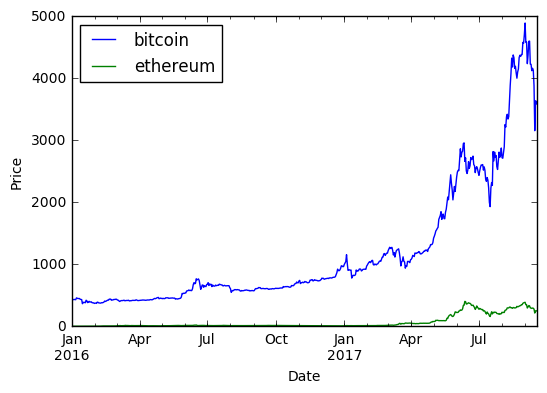

In [32]:
plot_data(df)

### Normalization

In [7]:
df_norm = df / df.ix[0, :]

In [13]:
print df_norm.head()

             bitcoin  ethereum
2016-01-01  1.000000  1.000000
2016-01-02  0.997951  0.988502
2016-01-03  0.990054  1.025190
2016-01-04  0.997145  1.006810
2016-01-05  0.994543  1.002270


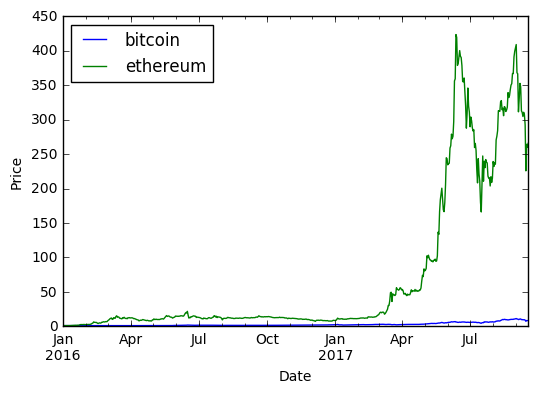

In [14]:
plot_data(df_norm)

### Global Stats

In [15]:
print df.mean()

bitcoin     1188.918674
ethereum      66.293175
dtype: float64


In [16]:
print df.median()

bitcoin     726.530
ethereum     11.975
dtype: float64


In [17]:
print df.std()

bitcoin     1041.288594
ethereum     105.938351
dtype: float64


Looks like BTC varies a lot more than ETH

### Rolling Means

In [68]:
def plot_rolling_mean(symbol):
    rm = pd.rolling_mean(df[symbol], window=20)
    plt.figure(figsize=(10,6))
    ax = df[symbol].plot(title=symbol)
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    rm.plot(label='Rolling Mean', ax=ax)
    plt.legend(loc='upper left')
    plt.show()

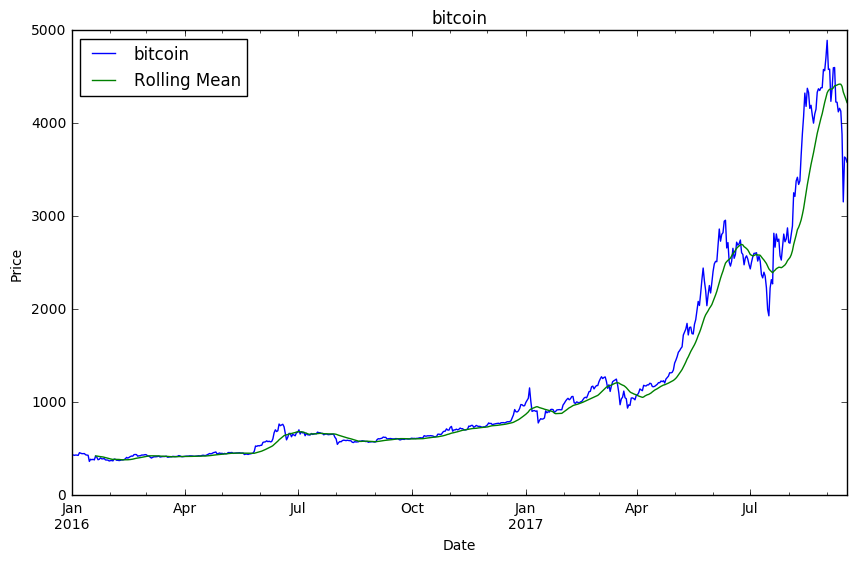

In [69]:
plot_rolling_mean('bitcoin')

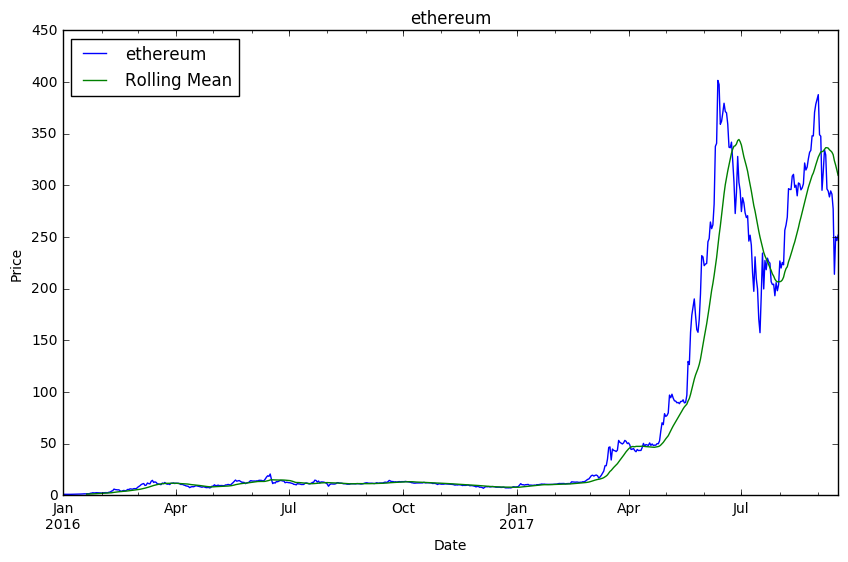

In [70]:
plot_rolling_mean('ethereum')

### Bollinger Bands

In [33]:
def get_rolling_mean(values, window):
    """Return rolling mean of given values, using specified window size."""
    return pd.rolling_mean(values, window=window)


def get_rolling_std(values, window):
    """Return rolling standard deviation of given values, using specified window size."""
    return pd.rolling_std(values, window=window)


def get_bollinger_bands(rm, rstd):
    """Return upper and lower Bollinger Bands."""
    upper_band = rm + 2*rstd
    lower_band = rm - 2*rstd
    return upper_band, lower_band

In [71]:
def plot_bollinger_bands(symbol):
    rm = get_rolling_mean(df[symbol], window=20)
    rstd = get_rolling_std(df[symbol], window=20)
    upper_band, lower_band = get_bollinger_bands(rm, rstd)
    
    plt.figure(figsize=(10,6))
    ax = df[symbol].plot(title=symbol)
    rm.plot(label='Rolling Mean', ax=ax)
    upper_band.plot(label='Upper Band', ax=ax)
    lower_band.plot(label='Lower Band', ax=ax)
    plt.legend(loc='upper left')
    plt.show()

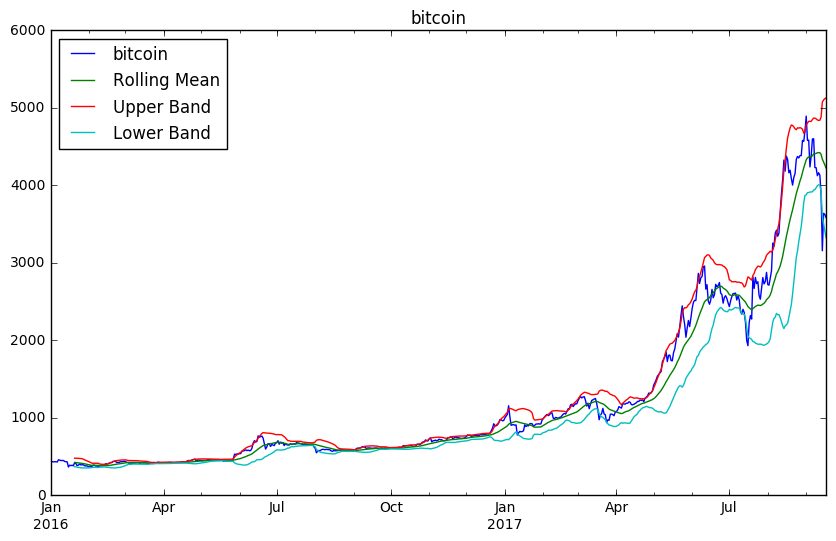

In [72]:
plot_bollinger_bands('bitcoin')

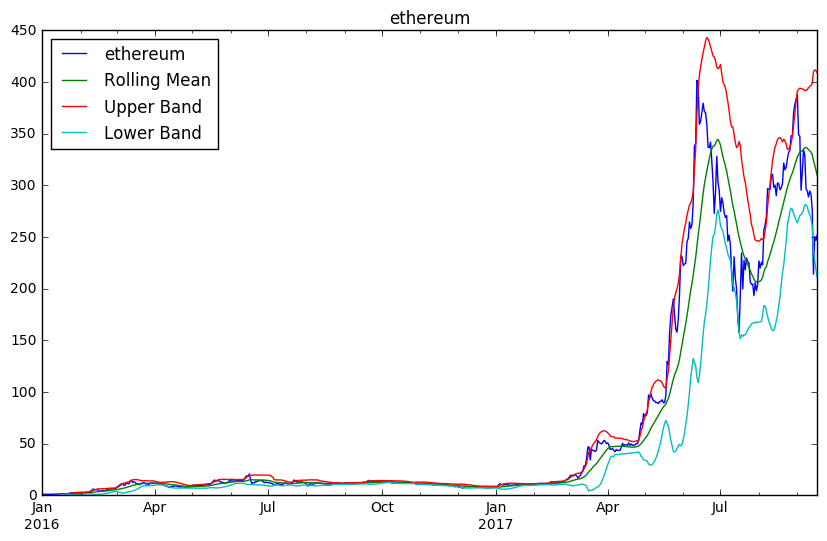

In [73]:
plot_bollinger_bands('ethereum')

Following Bollinger Bands won't be very good in this case.

### Daily Returns

In [62]:
def plot_data(df, title="", xlabel="Date", ylabel="Price"):
    ax = df.plot(title=title, fontsize=12)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()
    
def compute_daily_returns(df):
    """Compute and return the daily return values."""
    daily_returns = (df / df.shift(1)) - 1
    daily_returns.ix[0,:] = 0
    return daily_returns

def plot_daily_returns(df):
    daily_returns = compute_daily_returns(df)
    plot_data(daily_returns, title="Daily returns", ylabel="Daily returns")

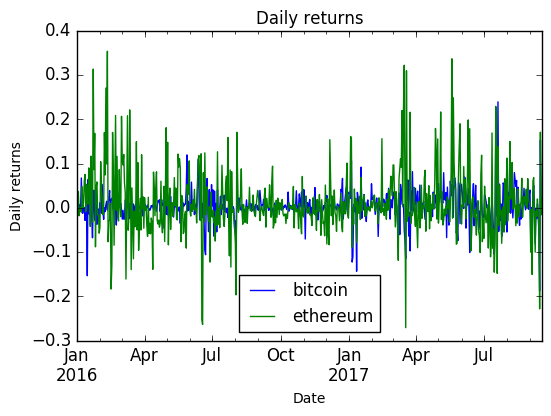

In [63]:
plot_daily_returns(df)

### Correlations

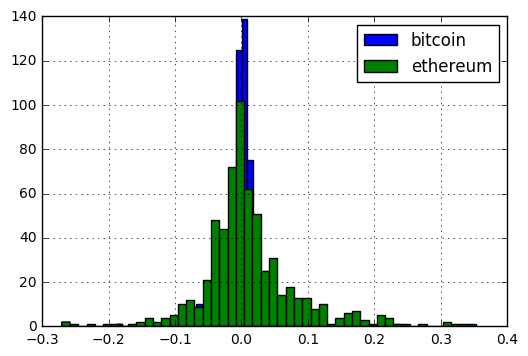

In [67]:
daily_returns = compute_daily_returns(df)
daily_returns['bitcoin'].hist(bins=50, label='bitcoin')
daily_returns['ethereum'].hist(bins=50, label='ethereum')
plt.legend(loc='upper right')
plt.show()

In [75]:
print daily_returns.mean()

bitcoin     0.003992
ethereum    0.011546
dtype: float64


In [76]:
print daily_returns.std()

bitcoin     0.035103
ethereum    0.073450
dtype: float64


In [74]:
print daily_returns.kurtosis()

bitcoin     7.474608
ethereum    3.933589
dtype: float64


Both of them have fat tails.

0.538633752026 0.00939517792645


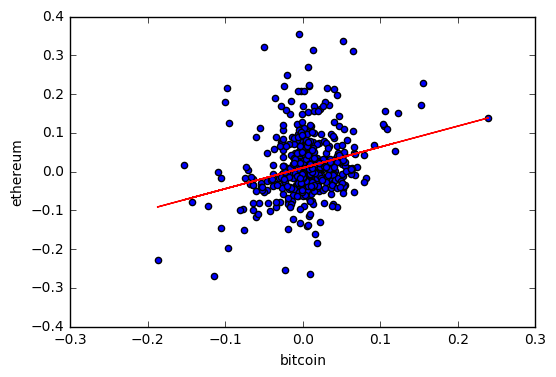

In [86]:
daily_returns.plot(kind='scatter', x='bitcoin', y='ethereum')
beta, alpha = np.polyfit(daily_returns['bitcoin'], daily_returns['ethereum'], 1)
print beta, alpha
plt.plot(daily_returns['bitcoin'], beta*daily_returns['bitcoin']+alpha, '-', color='r')
plt.show()